# **You Only Look Once (YOLO): Object Detection Using Deep Convolutional Networks**

## 1. Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>
<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we use 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large.

In [ ]:
# Import all modules
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import torch
import torch.nn as nn
import torchvision

from sklearn import metrics

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed);

In [ ]:
# Mount drive for data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/cis680

/content/drive/MyDrive/cis680


## 2. Data Preprocessing
This section preprocesses the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>
<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, we convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The details of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, we convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), we don't assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

In [ ]:
# Import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz')
raw_labels = load_data('labels.npz')

In [ ]:
# This function computes the 8X8X8 label from the raw labels for the corresponding image.
def process_labels_all(raw_labels):
    labels = np.zeros((8, 8, 8))
    w, h = abs(raw_labels[:, 1]- raw_labels[:, 3]), abs(raw_labels[:, 2]- raw_labels[:, 4])
    x, y = raw_labels[:, 1] + w/2, raw_labels[:, 2] + h/2 

    encoded_class = np.zeros((len(raw_labels), 3))
    encoded_class[np.arange(len(raw_labels)),raw_labels[:, 0].astype(int)] = 1

    x_grid, y_grid = (x//16).astype(int), (y//16).astype(int)
    x_relative, y_relative = abs(x -(x_grid * 16))/16, abs(y- (y_grid * 16))/16

    rect = np.vstack((x_relative,y_relative))
    rect = np.vstack((rect, w/128))
    rect = np.vstack((rect, h/128))
    
    labels[x_grid, y_grid, 0] = 1
    labels[x_grid, y_grid, 1:5] = rect.T
    labels[x_grid, y_grid, 5:] = encoded_class
    labels = np.moveaxis(labels, -1, 0)

    return labels

In [ ]:
# This function performs the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    idx = np.argwhere(labels[0, :, :]>0)
    raw_labels = np.empty((0, 5))
    for i in idx:
      arr = labels[:, i[0], i[1]]
      new_label = np.zeros(5)
      new_label[0] = np.argmax(arr[5:])
      new_label[1] = (i[0] + arr[1] - arr[3]*4)*16 
      new_label[2] = (i[1] + arr[2] - arr[4]*4)*16 
      new_label[3] = (i[0] + arr[1] + arr[3]*4)*16 
      new_label[4] = (i[1] + arr[2] + arr[4]*4)*16 
      raw_labels = np.vstack((raw_labels, new_label))
    return raw_labels

# This function reconstruct labels to output format list[(n x 6)]
def reconstructed_nms(nms_out):
    idx = torch.nonzero((nms_out[:, 0]))
    final_list = []
    for img in nms_out:
      idx = torch.nonzero(img[0])
      labels = torch.max(img[5:, idx[:, 0], idx[:, 1]], dim=0)[1]
      scores = img[0, idx[:, 0], idx[:, 1]]
      arr = torch.zeros((len(labels), 6))
      arr[:, 0] = labels.int()
      arr[:, 1] = scores
      arr[:, 2:] = img[1:5, idx[:, 0], idx[:, 1]].T
      if (img == 0).sum() ==  0:
        arr[:, :] = 0
      final_list.append(arr.detach().numpy())
    return final_list

## 3. Model Architecture
We implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


In [ ]:
# YOLO Model Class
class YOLO(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(256)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
    self.bn5 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(1024)
    self.trans_conv7 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1)
    self.bn7 = nn.BatchNorm2d(256)
    self.trans_conv8 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.bn8 = nn.BatchNorm2d(64)
    self.conv9 = nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.relu = nn.ReLU()
    self.sign = nn.Sigmoid()

  def forward(self, x):
    x = x.float()
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    x = self.relu(self.bn3(self.conv3(x)))
    x = self.relu(self.bn4(self.conv4(x)))
    x = self.relu(self.bn5(self.conv5(x)))
    x = self.relu(self.bn6(self.conv6(x)))
    x = self.relu(self.bn7(self.trans_conv7(x)))
    x = self.relu(self.bn8(self.trans_conv8(x)))
    x = self.sign(self.conv9(x))
    return x

  def load_from_url():
    checkpoint = "https://drive.google.com/drive/folders/1VeoXm_76i8y05I9SHabPR8NzpcWyP00O?usp=sharing"
    model = YOLO()
    model.load_state_dict(torch.hub.load_state_dict_from_url(checkpoint, progress=True, map_location=torch.device('cpu')))
    return model


In [ ]:
# This function calculates Vectorized IOU matrix between target and output
def IOU(output, target):
  # Get x,y,w,h
  predict_bb = output[:, 1:5].to(device)
  target_bb = target[:, 1:5].to(device)

  # Get width and height
  pred_width, pred_height = predict_bb[:, 2] * 128, predict_bb[:, 3] * 128
  target_width, target_height = target_bb[:, 2] * 128, target_bb[:, 3] * 128

  # Get coordinates from centers
  x1, y1 = predict_bb[:, 0] * 16 - pred_width/2, predict_bb[:, 1] * 16  - pred_height/2
  x2, y2 = predict_bb[:, 0] * 16 + pred_width/2, predict_bb[:, 1] * 16  + pred_height/2

  x3, y3 = target_bb[:, 0] * 16 - target_width/2, target_bb[:, 1] * 16 - target_height/2
  x4, y4 = target_bb[:, 0] * 16 + target_width/2, target_bb[:, 1] * 16 + target_height/2
  
  x_top_left, y_top_left = torch.max(x1, x3).to(device), torch.max(y1, y3).to(device)
  x_bot_right, y_bot_right = torch.min(x2, x4).to(device), torch.min(y2, y4).to(device)

  # Find intersection
  intersection = torch.max((x_bot_right - x_top_left), torch.zeros_like(x_bot_right)) * torch.max((y_bot_right - y_top_left), torch.zeros_like(y_bot_right))
  # Find Union
  union = ((x2 - x1) * (y2 - y1)) + ((x4 - x3) * (y4 -y3)) - intersection + 1e-6
  # Compute IoU
  iou = (intersection / union)

  return iou

## 4. Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, we set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2.

In [ ]:
# YOLO Loss Function
def yolo_loss(output, target):
  lambda_coord = 5
  lambda_noobj = 0.5

  iou = IOU(output, target)
  objectness_pred = output[:, 0].clone()
  objectness_target = target[:, 0].clone()

  # Location Loss
  location_xy = lambda_coord * (torch.sum((((target[:, 1][objectness_target.to(torch.bool)] - output[:, 1][objectness_target.to(torch.bool)]) ** 2) +((target[:, 2][objectness_target.to(torch.bool)] - output[:, 2][objectness_target.to(torch.bool)]) ** 2)  ) ))
  location_wh = lambda_coord * (torch.sum((((torch.sqrt(target[:, 3][objectness_target.to(torch.bool)]) - torch.sqrt(output[:, 3][objectness_target.to(torch.bool)])) ** 2) +
                                                               ((torch.sqrt(target[:, 4][objectness_target.to(torch.bool)]) - torch.sqrt(output[:, 4][objectness_target.to(torch.bool)])) ** 2)) ))
  
  location_loss = location_xy + location_wh

  # Confidence Loss
  object_loss = torch.sum(torch.square((target[:, 0][objectness_target.to(torch.bool)] - output[:, 0][objectness_target.to(torch.bool)])))

  no_object_loss = lambda_noobj * torch.sum((1 - objectness_target) * ((objectness_target - objectness_pred)**2))
  confidence_loss = object_loss + no_object_loss

  # Class loss
  class_loss = torch.sum(torch.square(objectness_target * (target[:, 5] - output[:, 5])) + torch.square(objectness_target * (target[:, 6] - output[:, 6])) + torch.square(objectness_target * (target[:, 7] - output[:, 7])))

  # Total Loss
  loss = location_loss + confidence_loss + class_loss

  return loss, location_wh, location_wh, class_loss, object_loss, no_object_loss

## 5. Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of our YOLO implementation, we compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of our network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>
<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

In [ ]:
# This function computes IOU between two bbox of grid cells
def get_iou_group(grid, cell, neighbor):
    # Get width and height
    cell_width, cell_height  = grid[3, cell[0], cell[1]] * 128, grid[4, cell[0], cell[1]] * 128
    neighbor_width, neighbor_height  = grid[3, neighbor[0], neighbor[1]] * 128, grid[4, neighbor[0], neighbor[1]] * 128

    # Get coordinates from centers
    x1, y1 = grid[1, cell[0], cell[1]] * 16 - cell_width/2, grid[2, cell[0], cell[1]] * 16  - cell_width/2
    x2, y2 = grid[1, cell[0], cell[1]] * 16 + cell_width/2, grid[2, cell[0], cell[1]] * 16  + cell_width/2

    x3, y3 = grid[1, neighbor[0], neighbor[1]] * 16 - neighbor_width/2, grid[2, neighbor[0], neighbor[1]] * 16  - neighbor_width/2
    x4, y4 = grid[1, neighbor[0], neighbor[1]] * 16 + neighbor_width/2, grid[2, neighbor[0], neighbor[1]] * 16  + neighbor_width/2

    # Get bbox
    x_top_left, y_top_left = torch.max(x1, x3), torch.max(y1, y3)
    x_bot_right, y_bot_right = torch.min(x2, x4), torch.min(y2, y4)

    intersection = torch.max((x_bot_right - x_top_left), torch.zeros_like(x_bot_right)) * torch.max((y_bot_right - y_top_left), torch.zeros_like(y_bot_right))
    union = ((x2 - x1) * (y2 - y1)) + ((x4 - x3) * (y4 -y3)) - intersection + 1e-6
    
    iou = (intersection / union)

    return iou


# Low Confidence Supression
def low_confidence_suppression(label):
    pred = label.clone()
    mask = pred[:, 0, :, :] > 0.6
    pred *= mask[:, None, :, :]
    return pred


# Non Max Supression
def non_max_suppression(label):
    pred = label.clone()
    
    for img in range(len(label)):
      for cls in [0, 1, 2]:
        # Creates masks for right confidence and right class
        conf_mask = pred[img, 0, :, :] > 0.6
        class_mask = torch.max(pred[img, 5:, :, :], axis=0)[1] == cls

        # Create index list for both conditions true
        cls_idx = torch.logical_and(class_mask, conf_mask).nonzero()

        for cell in cls_idx:
          conf_cell = pred[img, 0, cell[0], cell[1]] * pred[img, 5+cls, cell[0], cell[1]]
        
          for neighbor in cls_idx:
            conf_neighbor = pred[img, 0, neighbor[0], neighbor[1]] * pred[img, 5+cls, neighbor[0], neighbor[1]]

            overlap = get_iou_group(pred[img], cell, neighbor) > 0.5
            conf_max = conf_cell < conf_neighbor
            
            if overlap and conf_max:
              pred[img , :, cell[0], cell[1]] = 0

    return pred

In [ ]:
def precision_recall_curve(matches, scores, trues):    
    recall = np.zeros((101))
    precision = np.zeros((101))

    for i, threshold in enumerate(np.linspace(0.6, np.max(scores), 100)):
      true_pos = np.sum(matches[scores > threshold])
      pos = matches[scores > threshold].shape[0]
      precisions = 1

      if pos > 0:
        precisions = true_pos/pos
      
      recalls = 1
      if trues>0:
        recalls = true_pos/trues

      precision[i] = precisions
      recall[i] = recalls

    precision[100] = 1
    recall[100] = 0

    return recall, precision


def average_precision(recall, precision):
    idx = np.argsort(recall)
    recall = recall[idx]
    precision = precision[idx]
    area = metrics.auc(recall, precision)

    return area


def mean_average_precision(avg_precision, count):
    mean_average_precision = avg_precision / count
    return mean_average_precision


def yolo_evaluation(out_nms, target):
    iou_thresh = 0.5
    obj_idx = torch.nonzero(out_nms[:, 0])

    confi_scores = out_nms[obj_idx[:, 0], 0, obj_idx[:, 1], obj_idx[:, 2]] * (torch.max(out_nms[obj_idx[:, 0], 5:, obj_idx[:, 1], obj_idx[:, 2]], dim=1)[0])
    class_idx = torch.max(out_nms[obj_idx[:, 0], 5:, obj_idx[:, 1], obj_idx[:, 2]], dim=1)[1]

    iou = IOU(out_nms, target)
    iou = iou[obj_idx[:,0], obj_idx[:, 1], obj_idx[:, 2]]
    match = torch.gt(iou, iou_thresh)

    true_idx = torch.nonzero(target[:, 0])
    target_class = torch.max(target[true_idx[:, 0], 5:, true_idx[:, 1], true_idx[:, 2]], dim=1)[1]
    scores = {}
    trues = {}
    matches = {}

    for i in range(3):
      matches[i] = (match[class_idx == i]).cpu().tolist()
      scores[i] = (confi_scores[class_idx == i]).cpu().tolist()
      trues[i] = (torch.sum(target_class == i)).item()

    return matches, scores, trues

## 6. Implementation



### a.   Display Image and Bounding Boxes using target labels.



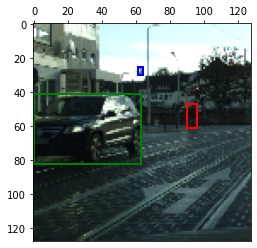

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized.
colors = ['r', 'b', 'g']
which = 531
# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.xaxis.tick_top()
ax.imshow(images[which])

# Create bounding box
for i in raw_labels[which]:
  rect = patches.Rectangle((i[1], i[2]), i[3]-i[1], i[4]-i[2], linewidth=2, edgecolor=colors[int(i[0])], facecolor='none')
  ax.add_patch(rect)

plt.show()

### b. Vizualize 8x8x8 labels as a heatmap.

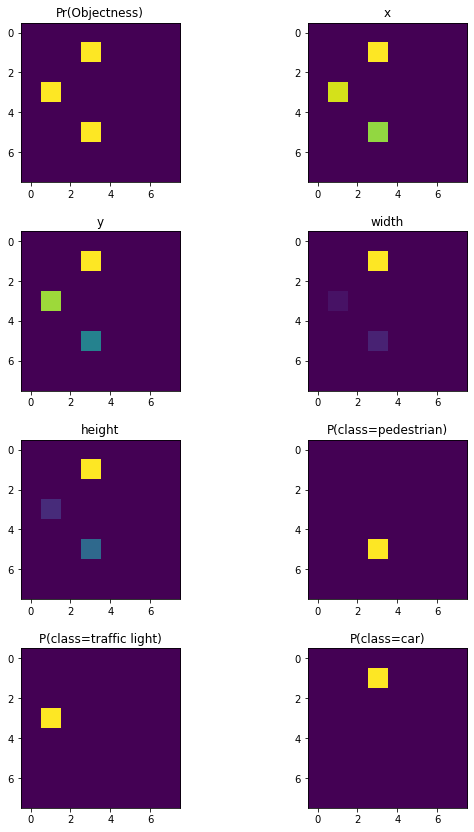

In [ ]:
# Visualize the 8x8x8 representation.
target = process_labels_all(raw_labels[which])

channels = ['Pr(Objectness)', 'x', 'y', 'width', 'height', 'P(class=pedestrian)', 'P(class=traffic light)', 'P(class=car)']

fig = plt.figure(figsize=(8, 15))
fig.subplots_adjust(hspace=0.1, wspace=0.8)

for i in range(8):
  ax = fig.add_subplot(4, 2, i+1)
  plt.title(channels[i])
  ax.imshow(target[i, :, :])

### c. Test reconstruction fuction and recover raw labels from 8x8x8 format.

In [ ]:
# Convert back to the original representation (test cases below should pass).
labels_reconstructed = reconstruct_raw_labels(target)
print('Reconstructed Labels\n', labels_reconstructed)
print('Original Labels\n', raw_labels[which])

Reconstructed Labels
 [[ 2.  0. 41. 63. 82.]
 [ 1. 61. 25. 64. 30.]
 [ 0. 90. 47. 96. 61.]]
Original Labels
 [[ 0. 90. 47. 96. 61.]
 [ 2.  0. 41. 63. 82.]
 [ 1. 61. 25. 64. 30.]]


### d. Load and Preprocess Data

In [ ]:
# Process all labels
labels = torch.empty((0, 8, 8, 8))
for i in range(len(raw_labels)):
  processed = process_labels_all(raw_labels[i])[None, :, :, :]
  labels = torch.vstack((labels, torch.from_numpy(processed)))

In [ ]:
# Convert input to numpy and flip axis
input = torch.from_numpy(np.moveaxis(images, -1, 1))

In [ ]:
# Making dataloader of input and labels
train_set = torch.utils.data.TensorDataset(input[:6900], labels[:6900])
val_set = torch.utils.data.TensorDataset(input[6900:], labels[6900:])

train_loader = torch.utils.data.DataLoader(
  train_set,
  batch_size = 64,
  shuffle=True
)
val_loader = torch.utils.data.DataLoader(
  val_set,
  batch_size = 1,
  shuffle=True
)

### e. Training Loop

In [ ]:
# Setup your training
model = YOLO().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4)
train_loss = []
location_loss = []
object_loss = []
noobject_loss = []
bounding_box_loss = []
class_loss = []
map_train = []
num_epochs = 50
for epoch in range(num_epochs):
  model.train()
  avg_precision_train=0
  count_train =0
  matches_train = {0:[],1:[],2:[]}
  scores_train = {0:[],1:[],2:[]}
  trues_train  = {0:0,1:0,2:0}
  print("Epoch %d/%d" % (epoch+1, num_epochs))
  for i, (data, target) in enumerate(train_loader):
    pred_y = model(data.to(device))
    if epoch%5 == 0:
      nms_out = non_max_suppression(pred_y) 
      m, s, t = yolo_evaluation(nms_out, target)
      for c in range(3): 
        matches_train[c].extend(m[c])
        scores_train[c].extend(s[c])
        trues_train[c] = trues_train[c] + t[c]

    loss, loc_loss, bounding_box, pr_class_loss, obj_loss, no_obj_loss  = yolo_loss(pred_y, target.to(device))
    # loss = yolo_loss_alt(pred_y, target.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss.append(loss.item())
  location_loss.append(loc_loss.item())
  bounding_box_loss.append(bounding_box.item())
  class_loss.append(pr_class_loss.item())
  object_loss.append(obj_loss.item())
  noobject_loss.append(no_obj_loss.item())

  if epoch%5 == 0:
    for c in range(3):
      match_arr  = np.asarray(matches_train[c])
      scores_arr = np.asarray(scores_train[c])
      trues_arr  = np.asarray(trues_train[c])

      recall, precision = precision_recall_curve(match_arr, scores_arr, trues_arr)
      area = average_precision(recall, precision)
      avg_precision_train = avg_precision_train + area
      count_train += 1;

    if count_train > 0:
      map = mean_average_precision(avg_precision_train, count_train)
      map_train.append(map)
    print('\n')
    print("Mean Average Precision: ",map)


Epoch 1/50


Mean Average Precision:  3.28679555380293e-05
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50


Mean Average Precision:  0.013677969674243118
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50


Mean Average Precision:  0.09163207866342192
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50


Mean Average Precision:  0.2911656386422146
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50


Mean Average Precision:  0.4726404103569107
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50


Mean Average Precision:  0.5932100094292981
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50


Mean Average Precision:  0.6108055429138731
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50


Mean Average Precision:  0.3878669388286718
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50


Mean Average Precision:  0.7757248550481693
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50


Mean Average Precision:  0.783808364

In [ ]:
#save model
model_path= "/content/drive/MyDrive/YOLO/model.pth"
torch.save(model.state_dict(), model_path)

### f. Training Metrics

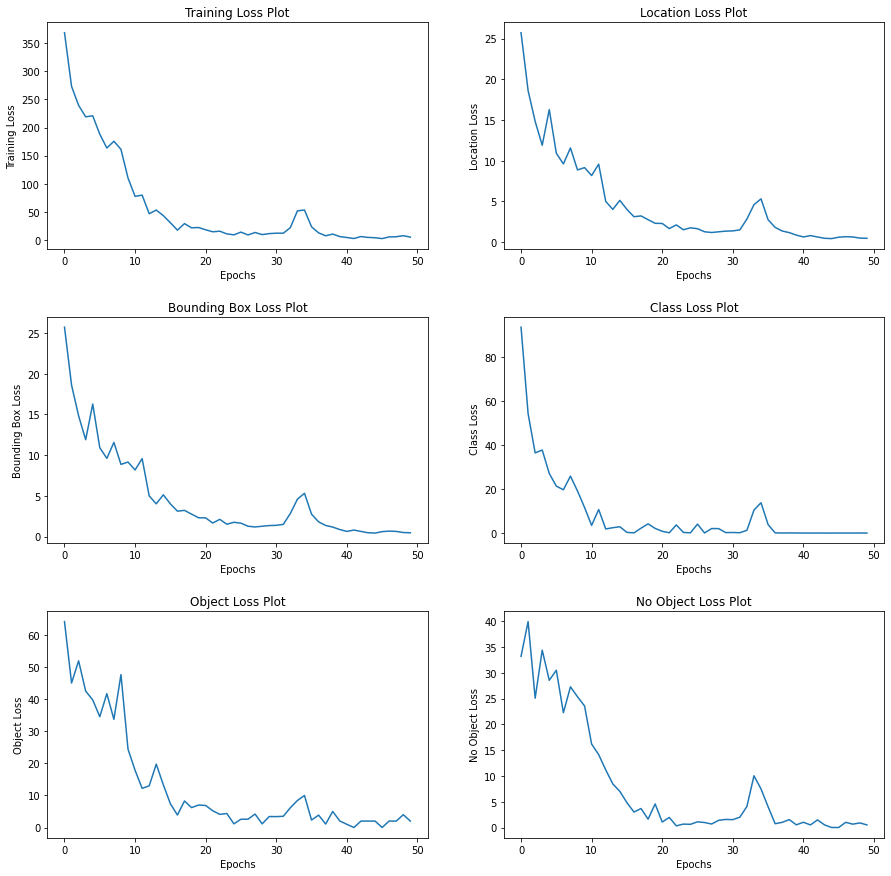

In [ ]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

ax = fig.add_subplot(3, 2, 1)
ax.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Plot")
plt.savefig("Loss_Training.png")

ax = fig.add_subplot(3, 2, 2)
ax.plot(location_loss)
plt.xlabel("Epochs")
plt.ylabel("Location Loss")
plt.title("Location Loss Plot")
plt.savefig("Loss_Localization.png")

ax = fig.add_subplot(3, 2, 3)
ax.plot(bounding_box_loss)
plt.xlabel("Epochs")
plt.ylabel("Bounding Box Loss")
plt.title("Bounding Box Loss Plot")
plt.savefig("bb_box_loss.png")

ax = fig.add_subplot(3, 2, 4)
ax.plot(class_loss)
plt.xlabel("Epochs")
plt.ylabel(" Class Loss")
plt.title("Class Loss Plot")
plt.savefig("class_loss.png")

ax = fig.add_subplot(3, 2, 5)
ax.plot(object_loss)
plt.xlabel("Epochs")
plt.ylabel("Object Loss")
plt.title("Object Loss Plot")
plt.savefig("obj_loss.png")


ax = fig.add_subplot(3, 2, 6)
ax.plot(noobject_loss)
plt.xlabel("Epochs")
plt.ylabel("No Object Loss")
plt.title("No Object Loss Plot")
plt.savefig("no_obj.png")

plt.show()

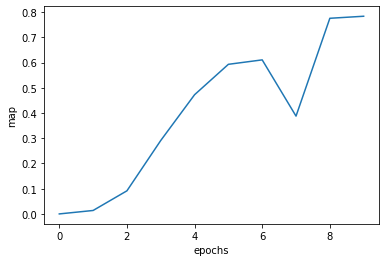

In [ ]:
  # Plot Mean Average Precision over training.
  plt.figure()
  plt.plot(np.arange(10), map_train)
  plt.xlabel("epochs")
  plt.ylabel("map")
  plt.show()

In [ ]:
test_img = torch.from_numpy(np.moveaxis(images[which][None, :, :, :], -1, 1)).to(device)
model.eval()
pred = model(test_img)

### g. Original and Post Processed Bounding boxes predicted by model.

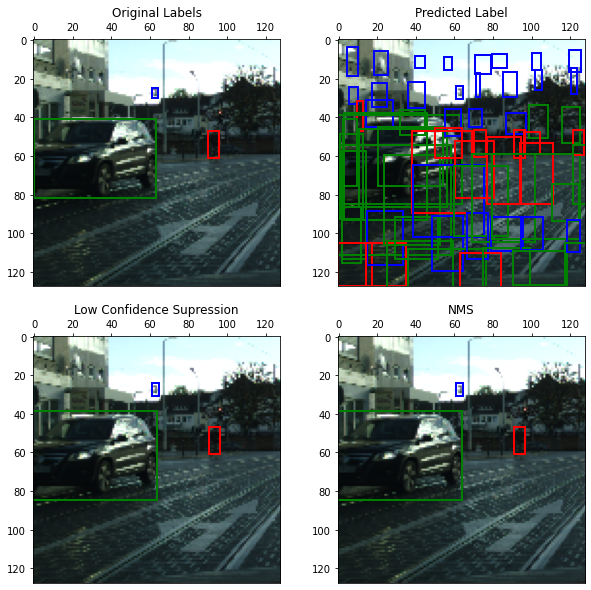

In [ ]:
# Create figure and axes
fig = plt.figure(figsize=(10, 10))

pred_plt = pred[0].cpu().detach().numpy()
label_op = reconstruct_raw_labels(pred_plt)

label_supp_plt = low_confidence_suppression(pred.cpu())
label_supp = reconstruct_raw_labels(label_supp_plt[0].cpu().detach().numpy())

label_nms_plt = non_max_suppression(label_supp_plt)
label_nms = reconstruct_raw_labels(label_nms_plt[0].cpu().detach().numpy())

lab = [raw_labels[which], label_op, label_supp, label_nms]
title = ['Original Labels', 'Predicted Label', 'Low Confidence Supression', 'NMS']

for id in range(4):
  ax = fig.add_subplot(2, 2, id+1)

  # Display the image
  ax.xaxis.tick_top()
  ax.imshow(images[which])
  plt.title(title[id])

  # Create bounding box
  for i in lab[id]:
    rect = patches.Rectangle((i[1], i[2]), i[3]-i[1], i[4]-i[2], linewidth=2, edgecolor=colors[int(i[0])], facecolor='none')
    ax.add_patch(rect)

plt.show()

### h. Testing Loop

In [ ]:
avg_precision=0
count =0
matches= {0:[],1:[],2:[]}
scores = {0:[],1:[],2:[]}
trues  = {0:0,1:0,2:0}

model.eval()
nms_labels = torch.empty((0, 8, 8, 8)).to(device)
for i,(val_data, val_labels) in enumerate(val_loader):
  val_data = val_data.to(device)
  val_labels = val_labels.to(device)
  predictions = model(val_data)
  nms_out = non_max_suppression(predictions) 
  nms_labels = torch.vstack((nms_labels, nms_out))     
  m, s, t = yolo_evaluation(nms_out, val_labels)

  for c in range(3): 
    matches[c].extend(m[c])
    scores[c].extend(s[c])
    trues[c] = trues[c] + t[c]


### i. Testing Metrics

In [ ]:
reconstructed_labels = []
for i in range(len(train_set)):
  reconstructed_labels.append(None)
reconstructed_nms_labels = reconstructed_nms(nms_labels)
reconstructed_labels.extend(reconstructed_nms_labels)

In [ ]:
np.savez('reconstructed_final', reconstructed_labels)

/usr/local/lib/python3.7/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Length of matches for class 0 26457
Length of scores for class 0 26457
Total trues of class 0 3375


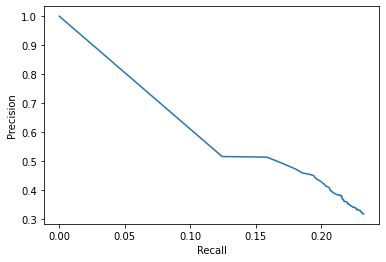

Length of matches for class 1 93772
Length of scores for class 1 93772
Total trues of class 1 794


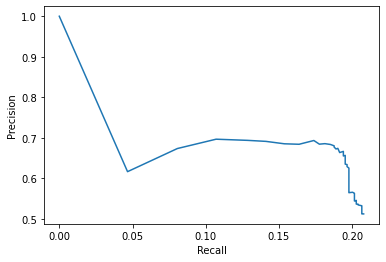

Length of matches for class 2 70614
Length of scores for class 2 70614
Total trues of class 2 8383


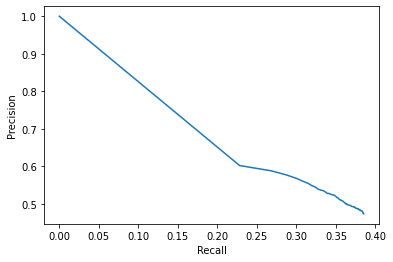



Mean Average Precision:  0.18620577911132807
Average Precision:  0.5586173373339842


In [ ]:
for c in range(3):
    print("Length of matches for class "+str(c), len(matches[c]))
    print("Length of scores for class "+str(c), len(scores[c]))
    print("Total trues of class "+str(c), trues[c])

    match_arr  = np.asarray(matches[c])
    scores_arr = np.asarray(scores[c])
    trues_arr  = np.asarray(trues[c])

    recall, precision = precision_recall_curve(match_arr, scores_arr, trues_arr)
    area = average_precision(recall, precision)
    avg_precision = avg_precision + area
    
    plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.savefig("Curve"+str(c)+".png")
    plt.show()
    count += 1;

if count > 0:
  map = mean_average_precision(avg_precision, count)

print('\n')
print("Mean Average Precision: ",map)
print("Average Precision: ", avg_precision)

## References

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection